# Observed Kappa
Find the observed kappa based on the activation diameters observed.

In [24]:
from closure_funcs import *
import numpy as np
from scipy.optimize import root_scalar
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from scipy.stats import linregress

In [25]:
d = pd.read_csv('../tables/merged.csv')
d['ams_tot'] = d.loc[:,['Org_Ave_IsoK_STP', 'SO4_Ave_IsoK_STP', 'NO3_Ave_IsoK_STP', 'NH4_Ave_IsoK_STP', 'Chl_Ave_IsoK_STP']].sum(axis=1)
merged = d
merged = merged[np.logical_not((merged['Ice_Flag_2DS']==1) | (merged['ED-liquid_2DS']>=60E-6) | (merged['LWC_FCDP']>0.005) | merged['ams_tot'] < 0.04)]
d = merged.reset_index(drop=True)

In [26]:
d['D_a'] = np.nan
for i in range(0,len(d)):
    d.loc[i,'D_a']

In [27]:
lower_bounds = [3.36, 3.76, 4.22, 4.74, 5.32, 5.97, 6.69, 7.51, 8.43, 9.46, 10.6, 11.9, 13.4, 15.0, 16.8, 18.9, 21.2, 23.8, 26.7, 29.9, 33.6, 37.6, 42.2, 47.4, 53.2, 59.7, 66.9, 75.1, 84.3, 93.9, 106.1, 119.0, 133.6, 149.9, 168.2, 188.7, 211.7, 237.5, 266.5, 299.0, 335.5, 376.5, 422.4, 473.9, 531.8, 596.6, 669.5, 751.1, 842.8, 945.6, 1129.5, 1421.9, 1790.1, 2253.6, 2837.1]
upper_bounds = [3.76, 4.22, 4.74, 5.32, 5.97, 6.69, 7.51, 8.43, 9.46, 10.6, 11.9, 13.4, 15.0, 16.8, 18.9, 21.2, 23.8, 26.7, 29.9, 33.6, 37.6, 42.2, 47.4, 53.2, 59.7, 66.9, 75.1, 84.3, 94.0, 106.1, 119.0, 133.6, 149.9, 168.2, 188.7, 211.7, 237.5, 266.5, 299.0, 335.5, 376.5, 422.4, 473.9, 531.8, 596.6, 669.5, 751.1, 842.8, 945.6, 1129.5, 1421.9, 1790.1, 2253.6, 2837.1, 3487.5]

dlogd=[]
for i in range(0,len(lower_bounds)):
       dlogd.append(np.log(upper_bounds[i]) - np.log(lower_bounds[i]))

In [28]:
b_l = ['SMPS_Bin02', 'SMPS_Bin03', 'SMPS_Bin04', 'SMPS_Bin05',
       'SMPS_Bin06', 'SMPS_Bin07', 'SMPS_Bin08', 'SMPS_Bin09', 'SMPS_Bin10',
       'SMPS_Bin11', 'SMPS_Bin12', 'SMPS_Bin13', 'SMPS_Bin14', 'SMPS_Bin15',
       'SMPS_Bin16', 'SMPS_Bin17', 'SMPS_Bin18', 'SMPS_Bin19', 'SMPS_Bin20',
       'SMPS_Bin21', 'SMPS_Bin22', 'SMPS_Bin23', 'SMPS_Bin24', 'SMPS_Bin25',
       'SMPS_Bin26', 'SMPS_Bin27', 'SMPS_Bin28', 'SMPS_Bin29', 'SMPS_Bin30',
       'LAS_Bin01', 'LAS_Bin02', 'LAS_Bin03', 'LAS_Bin04', 'LAS_Bin05',
       'LAS_Bin06', 'LAS_Bin07', 'LAS_Bin08', 'LAS_Bin09', 'LAS_Bin10',
       'LAS_Bin11', 'LAS_Bin12', 'LAS_Bin13', 'LAS_Bin14', 'LAS_Bin15',
       'LAS_Bin16', 'LAS_Bin17', 'LAS_Bin18', 'LAS_Bin19', 'LAS_Bin20',
       'LAS_Bin21', 'LAS_Bin22', 'LAS_Bin23', 'LAS_Bin24', 'LAS_Bin25',
       'LAS_Bin26']

In [29]:
def sum_dist_row(i, d, b_l, upper_bounds):
    row = d.loc[i]
    for j in range(0, len(b_l)):
        index = len(b_l) - j - 1
        conc = (row[b_l[index:]]*dlogd[index:]).sum()
        if conc > d.loc[i, 'N_CCN_stdPT']:
            return lower_bounds[index] +  .5*(upper_bounds[index] - lower_bounds[index])
    return None

# Parallel processing
d['D_a'] = Parallel(n_jobs=-1)(delayed(sum_dist_row)(i, d, b_l, upper_bounds) for i in tqdm(range(len(d))))

100%|██████████| 25349/25349 [00:13<00:00, 1833.52it/s]


In [30]:
def sum_dist_row(i):
    try:
        return find_k(d.loc[i, 'CCN_SS'], d.loc[i, 'D_a'])
    except:
        return np.nan

# Parallel processing
d['k_obs'] = Parallel(n_jobs=-1)(delayed(sum_dist_row)(i) for i in tqdm(range(len(d))))

100%|██████████| 25349/25349 [00:00<00:00, 25400.57it/s]


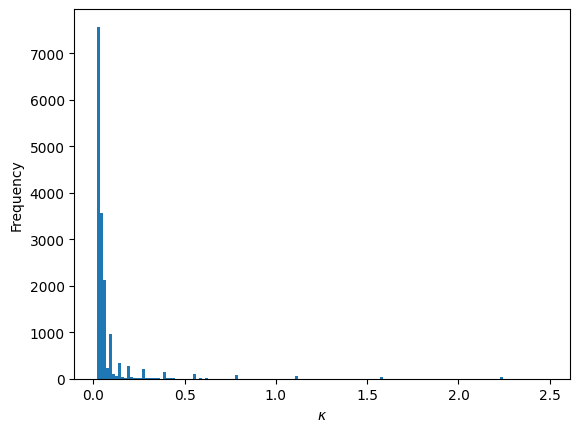

In [31]:
d['k_obs'].plot.hist(bins=150)
plt.xlabel('$\kappa$')
plt.savefig('../figures/k_obs_hist.png', dpi=300)

In [32]:
sub_m = d.copy().reset_index()
sub_m['D_c'] = np.nan
for i in tqdm(range(0,len(sub_m))):
    row = sub_m.iloc[i]
    if np.isfinite(row['k_obs']):
        sub_m.loc[i, 'D_c'] = find_d_act(row['CCN_SS'], row['k_obs'])

100%|██████████| 25349/25349 [00:04<00:00, 5310.17it/s]


In [33]:
sub_m2 = sub_m.copy()
sub_m2['CCN_n_pred'] = np.nan
bl_length = len(b_l)
#bin_pres_frac = []
for i in tqdm(range(0, len(sub_m2))):
    row = sub_m2.iloc[i]
    d_c = row['D_c']

    for j, ub in enumerate(upper_bounds):
        #print(lb)
        if d_c < ub:
            break
    
    bin_frac = (upper_bounds[j] - d_c) / (upper_bounds[j] - lower_bounds[j])

    count = 0
    if np.isfinite(row[b_l[j]]*bin_frac):
        sub_m2.loc[i, 'CCN_n_pred'] = row[b_l[j]]*bin_frac*dlogd[j]
        count+=1
    else:
        sub_m2.loc[i, 'CCN_n_pred'] = 0
    for k in range(j+1, bl_length):
        if np.isfinite(row[b_l[k]]):
            sub_m2.loc[i, 'CCN_n_pred'] += row[b_l[k]]*dlogd[k]
            count += 1
    if count/(bl_length-j) < .9:
        sub_m2.loc[i, 'CCN_n_pred'] = np.nan
    #bin_pres_frac.append(count/(bl_length-j))
sub_m2_og = sub_m2.copy()

100%|██████████| 25349/25349 [00:24<00:00, 1043.84it/s]


Text(0.5, 0, 'Measured CCN [cm$^{-3}$]')

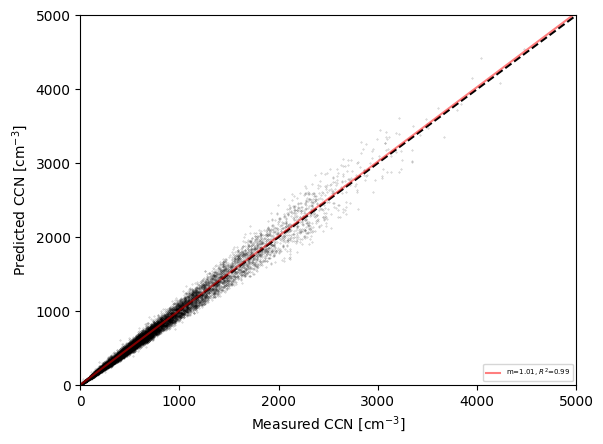

In [38]:
merged = sub_m2_og
plt.scatter(merged['N_CCN_stdPT'], merged['CCN_n_pred'], s=.1, c='black', alpha=.3)
plt.plot([0,5000], [0,5000], c='black', ls='--')
plt.xlim([0,5000])
plt.ylim([0,5000])
md = merged[['N_CCN_stdPT', 'CCN_n_pred']].dropna()
slope, intercept, r_value, p_value, std_err = linregress(md['N_CCN_stdPT'], md['CCN_n_pred'])
# Calculate the line of best fit
fit_line = slope * np.linspace(0, 5000) + intercept
plt.plot(np.linspace(0, 5000), fit_line, c='r', label=f'm={slope:.2f}, $R^2$={r_value**2:.2f}', alpha=.5)
plt.legend(fontsize=5, loc='lower right')


plt.ylabel('Predicted CCN [cm$^{-3}$]')
plt.xlabel('Measured CCN [cm$^{-3}$]')

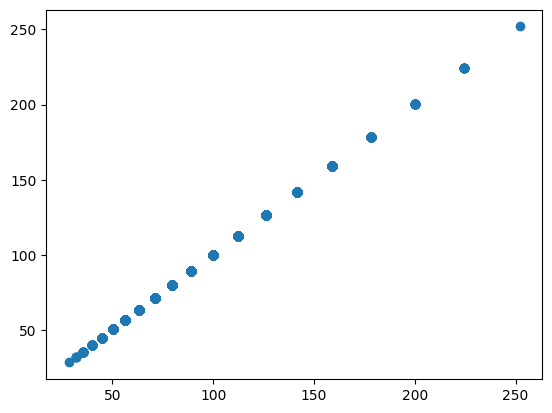

In [36]:
plt.scatter(merged['D_a'], merged['D_c'])

In [37]:
merged.to_csv('../tables/merged_observed.csv')